In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model

from utils.acdc_dataset import *
from utils.training import *
from utils.vqVAE_EMA import *



## Preparing Dataset 

In [2]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [3]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")



#### Segmentation Dataset

In [4]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)



## Prepairing the model

In [5]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 
downsampling_factor = 4

In [6]:
# ACDC_VQVAE = VQVAE(in_channels, D, K, downsampling_factor)
ACDC_VQVAE_EMA = VQVAE(in_channels, D, K, downsampling_factor)


## Training the Model

In [7]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



True
cuda:0


In [8]:
### Learning parameters

model = ACDC_VQVAE_EMA.to(device)

lr = 5e-4
epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models_EMA/vqvae_300_bestmodel.pth'

In [9]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [11]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, indices, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, indices, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += commit_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, F.mse_loss, device)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:05<00:00, 20.37batch/s, loss=1.39]


SolveValueException: Failed to solve values of expressions. Found contradictory values {16, 1} for equivalent expressions {'h', '1', '16'}
Input:
    'h [c] d = 1 512 64'
    'h b n = 16 32 32'
    'h b n d = None'
    '1 = 1'


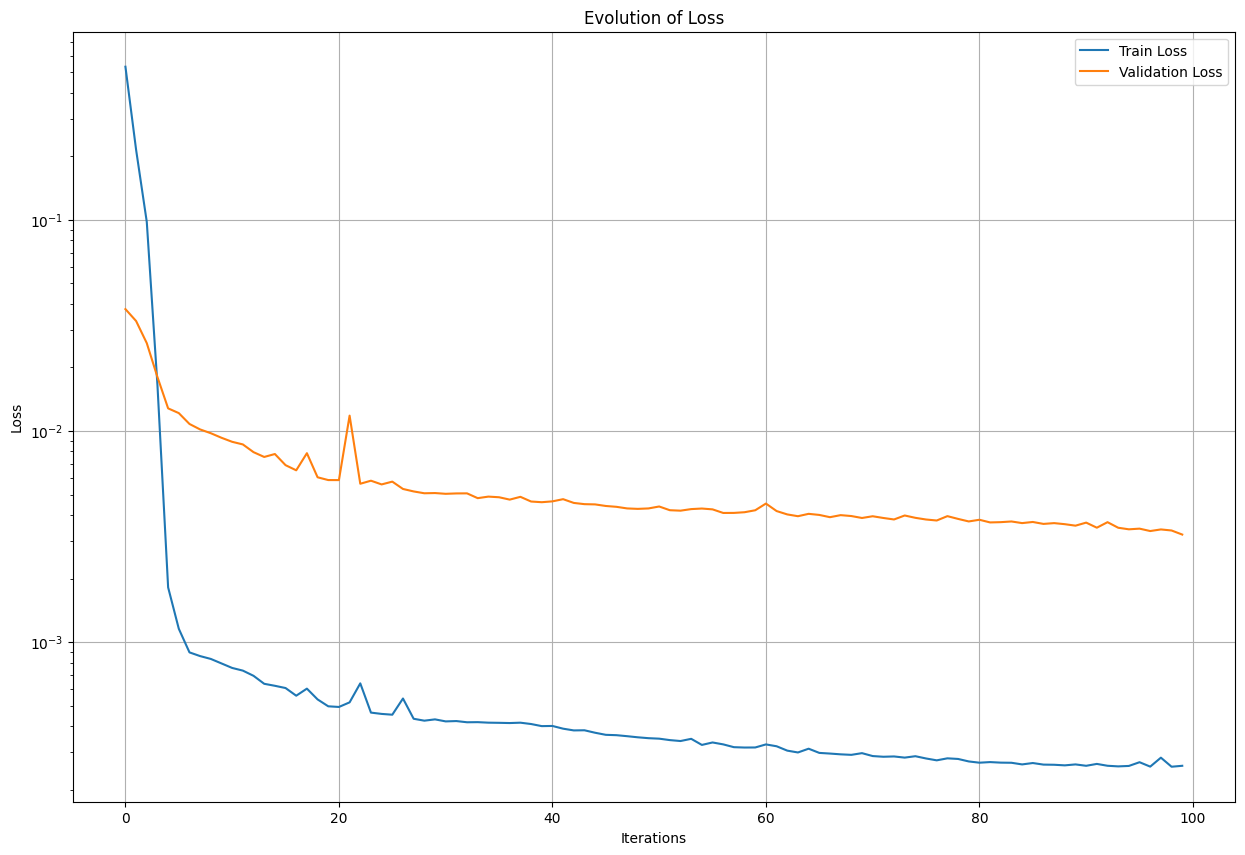

In [17]:
# Plot the training and validation losses
plot_train_val_loss(train_loss_values, val_loss_values)

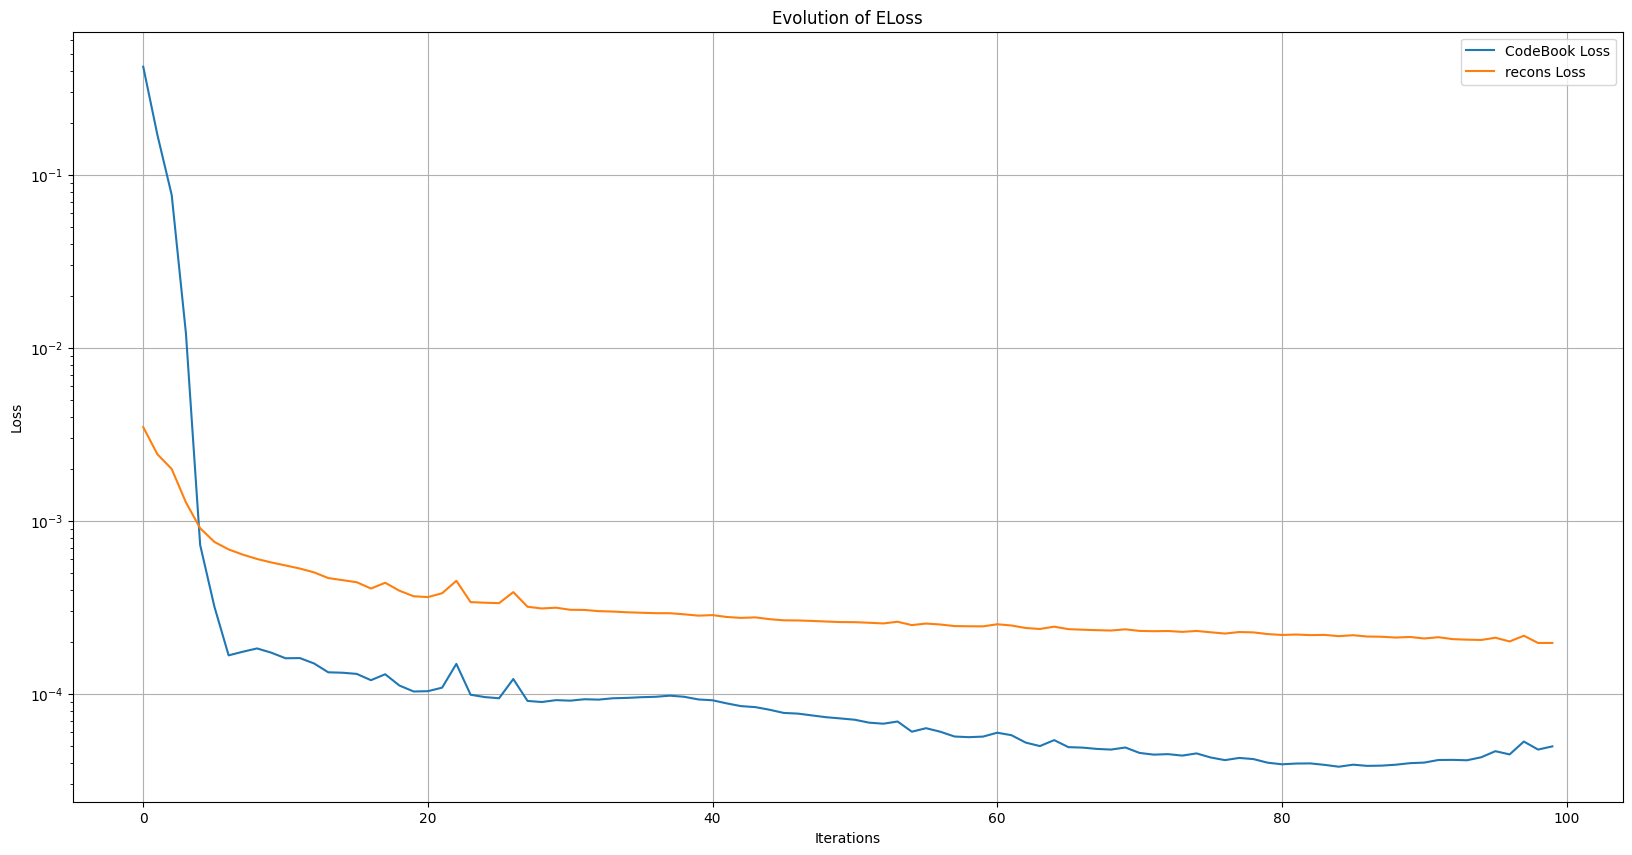

In [18]:

plot_rc_loss(train_loss_values, codebook_loss_values, beta=0.25)


# Test ...

In [ ]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

In [20]:
batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

In [ ]:
visualize_batch_logits(recons_evolution[-1].detach().cpu(), title = "g")